# HW2: Model Explanability

## 1. Load data for modeling.  This data represents taxi rides in NY (from a Kaggle competition)

In [1]:
import math
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

In [2]:
# Download the data (public github)
import requests
urls = [
    "https://github.com/rfox12-edu/explainability-sandbox/raw/main/x_train.parquet.gzip",
    "https://github.com/rfox12-edu/explainability-sandbox/raw/main/x_test.parquet.gzip",
    "https://github.com/rfox12-edu/explainability-sandbox/raw/main/y_train.parquet.gzip",
    "https://github.com/rfox12-edu/explainability-sandbox/raw/main/y_test.parquet.gzip"
]

# file names
file_names = [
    "x_train.parquet.gzip",
    "x_test.parquet.gzip",
    "y_train.parquet.gzip",
    "y_test.parquet.gzip"
]

# download files
for url, file_name in zip(urls, file_names):
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f"{file_name} downloaded successfully.")


x_train.parquet.gzip downloaded successfully.
x_test.parquet.gzip downloaded successfully.
y_train.parquet.gzip downloaded successfully.
y_test.parquet.gzip downloaded successfully.


In [3]:
# Load the data into pandas dataframes
x_train = pd.read_parquet('x_train.parquet.gzip')
x_test = pd.read_parquet('x_test.parquet.gzip')
y_train = pd.read_parquet('y_train.parquet.gzip')
y_test = pd.read_parquet('y_test.parquet.gzip')

## 2. Model Build

### Random Forest Regression

In [4]:
regr_rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf = 4,
    min_samples_split = 3, n_estimators = 40, n_jobs = -1)
regr_rf.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [5]:
y_train_pred_rf = regr_rf.predict(x_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)

y_pred_rf = regr_rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('Train MSE', mse_train_rf)
print('Test MSE', mse_rf)

Train MSE 83.15282049252697
Test MSE 165.94546983285883


### XGboost Regression

In [6]:
regr_xgb = xgb.XGBRegressor(
    learning_rate=0.1, n_estimators=1000, max_depth=3, min_child_weight=3,
    gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.8, n_jobs=-1
)
regr_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# Predicting on train & test data using our trained XgBoost regressor model
y_train_pred_xgb = regr_xgb.predict(x_train)
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)

y_pred_xgb = regr_xgb.predict(x_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print('Train MSE', mse_train_xgb)
print('Test MSE', mse_xgb)

Train MSE 158.25163804732728
Test MSE 168.04553550344372


### Feed forward NN: MLP

In [8]:
regr_mlp = MLPRegressor(
        hidden_layer_sizes=[50, 25],
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=33
)
regr_mlp.fit(x_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[50, 25], random_state=33)

In [9]:
y_train_pred_mlp = regr_mlp.predict(x_train)
mse_train_mlp = mean_squared_error(y_train, y_train_pred_mlp)

y_pred_mlp = regr_mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

print('Train MSE', mse_train_mlp)
print('Test MSE', mse_mlp)

Train MSE 166.36158474862742
Test MSE 163.90548439517625


### Q1 (5pts): Which model is the most over-fit to its training data?

The Random Forest Model is most Overfit to its training data. It has a Test-Train MSE Gap of ~82 compared to the other models gaps of ~10 and ~3. 

### Q2 (5pts): Is AUC an appropriate metric to evaluate these models?  Why or why not?

AUC wouldn’t be a good metric to for these regresion models. AUC is typically used as a metric for classifcation models, because it works by measuring the comparing predicted probabilities against binary labels. With regression models we are trying to predict a continous outcome, not a binary label, so we will look at other metrics such as MSE, RMSE, R-Squared. 

# Global Explanability

## Random Forest Feature Importance

### Q3 (5pts): Why is it important to look the overall predictive power of a model before looking at feature importance for that model?

It’s good practice to review a model’s predictive power before looking at feature importance. If we have a model with poor predictive power, it won’t provide us with any meaningful insights, because the model isn’t accurately capturing the relationship between features and the target variable. We need to have a well-performing model, so we can ensure that feature importance is providing valid information to us. 

### Q4 (5pts): How could you validate that these regression models are providing any predictive power at all? [you do not have to write code to answer this question]

We can ensure that these regression models are propviding predtive power by looking at metrics such as R-Squared MSE RMSE. We see as R-Squared gets closer to 1 it indicates a stronger predictive power. We see that lower MSE/RMSE scores indicate stronger predictive power as well. 

In [10]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ':  FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [11]:
def permutation_based_feature_importance(x_test, y_test, initial_mse, model):

    # Initialize an array to store feature importances
    feature_importances = np.zeros(x_test.shape[1])

    # Number of permutation iterations (you can adjust this value)
    num_iterations = 100

    # Calculate feature importance by permuting one feature at a time
    ####################### CODE HERE ############################
    for feature in range(x_test.shape[1]):
        print('Permuting feature ',feature + 1)
        # Copy the original test data
        x_test_permuted = x_test.copy()

        # Shuffle the values of the current feature
        permuted_column = x_test_permuted.iloc[:, feature]
        np.random.shuffle(permuted_column)
        x_test_permuted.iloc[:, feature] = permuted_column

        # Calculate the accuracy with the permuted feature
        permuted_mse = mean_squared_error(y_test, model.predict(x_test_permuted))

        # Calculate the drop in accuracy and store it as feature importance
        feature_importances[feature] = initial_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()

    # Get the names of the features (assuming X is a DataFrame)
    feature_names = x_test.columns

    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)

    return feature_importances[sorted_idx]

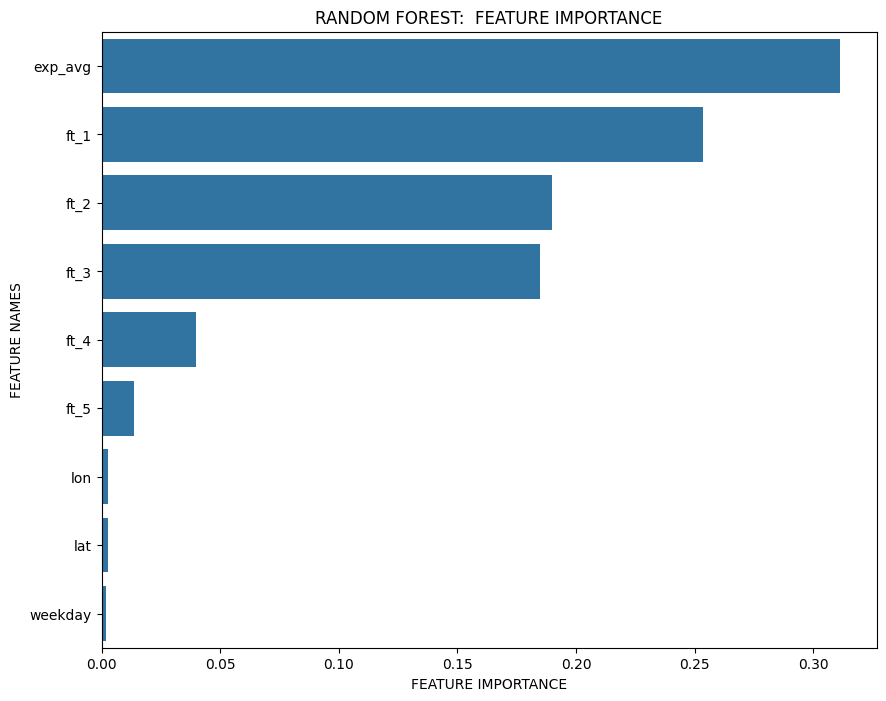

In [12]:
plot_feature_importance(regr_rf.feature_importances_,x_train.columns,'RANDOM FOREST')

In [13]:
permutation_based_feature_importance_rf = permutation_based_feature_importance(x_train, y_train, mse_train_rf, regr_rf)

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


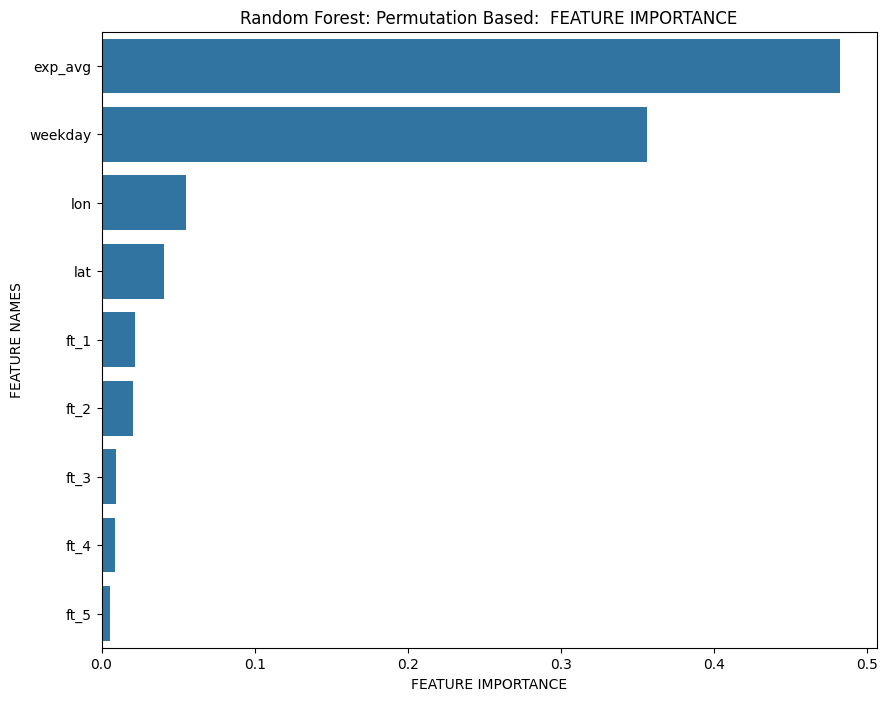

In [14]:
plot_feature_importance(permutation_based_feature_importance_rf,x_train.columns,'Random Forest: Permutation Based')

### Q5 (5pts): Is the `weekday` feature important to the `regr_rf` model?

Weekday is an important feature in the Regr_RF model. In the regular feature importance ranking, it comes in last, which could be due to the fact that these models are biased towards features with many categories and continous variables. The permutation model accounts for this limitations and ranks the weekday feature as the second most important feature. 

### Q6 (5pts): Is the `weekday` feature important to predicting the target?

The weekday feature is important for predicing the target. With the Permutation Based Feature Importance, it ranks second. As stated above I think this is the better measure of feature importance compared to that Gini-based model. 

### Q7 (10pts): Is the `.feature_importances_` of the `regr_rf` model reliable?  Why or why not?  [hint](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

I don't think this version of the feature importance is reliable. As stated above one of the limitations of that it ranks features with many categories (high cardinaility) or continous varibles much higher. The permutation-based feature importance accounts for this limitation. 

### Q8 (5pts): Are there any highly correlated features in this dataset?  Which ones?

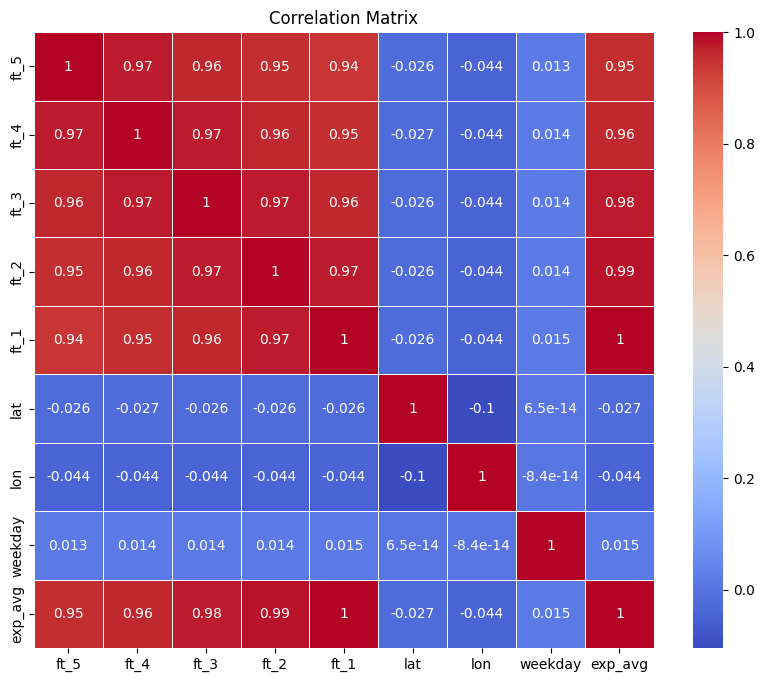

Top 5 most correlated features:
ft_1     exp_avg    0.997940
exp_avg  ft_1       0.997940
ft_2     exp_avg    0.986575
exp_avg  ft_2       0.986575
         ft_3       0.975550
dtype: float64


In [42]:
# Calculate the correlation matrix
corr_matrix = x_train.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Listing the top 5 most correlated features
correlation_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = correlation_pairs[correlation_pairs < 1].head(5)

print("Top 5 most correlated features:")
print(high_corr_pairs)


There are a ton of highly correlated features in this dataset: 

- ft_1
- ft_2
- ft_3
- ft_4
- ft_5
- exp_avg

### Q9 (5pts): What is the impact of highly correlated features on the analysis of feature importance for these models?

These highly correlated features cause multicollinearity, which negatively impacts the analysis of feature importance in models. When we have a bunch of highly correlated features, its difficult to determine the individual effects on the target variable and can lead to unreliable feature importance scores. 

## Random Forest Feature Analysis

In [15]:
from sklearn.inspection import PartialDependenceDisplay

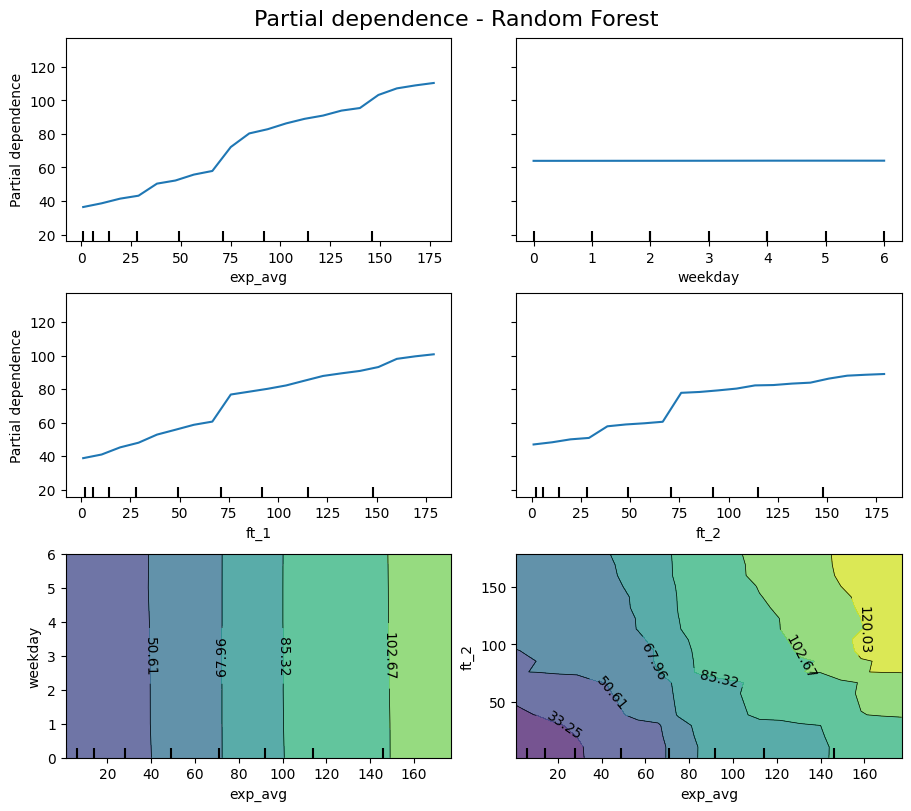

In [16]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # features of interest
    "features": ["exp_avg", 'weekday', 'ft_1', 'ft_2', ("exp_avg", 'weekday'), ("exp_avg", 'ft_2')],
    # type of partial dependence plot
    "kind": "average"
}

_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_rf,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - Random Forest"),fontsize=16)

### Q8 (5pts): Explain the partial dependence plot of 'exp_avg'.

The partial depedence plot in the top left shows an upward trend. This indicates that the feature has a positive relationship with the target variable so as exp_avg increases so does the target variable. This is showing that exp_avg is an important feature.

### Q9 (10pts): Is there any interaction between 'exp_avg' and 'weekday'? How about 'exp_avg' and 'ft_2'?


The Weekday/EXP_AVG plot shows flat lines indicating there isn't really a relationship between the two features. However FT_2/EXP_AVG do show a more curved line suggesting as both features increase, their combined presence leads to higher predicted values.

In [17]:
!pip install shap

In [18]:
import shap

In [19]:
explainer_rf = shap.Explainer(regr_rf, x_train)

In [20]:
shap_values_rf = explainer_rf(x_test[0:1000])

 94%|=================== | 945/1000 [00:16<00:00]       

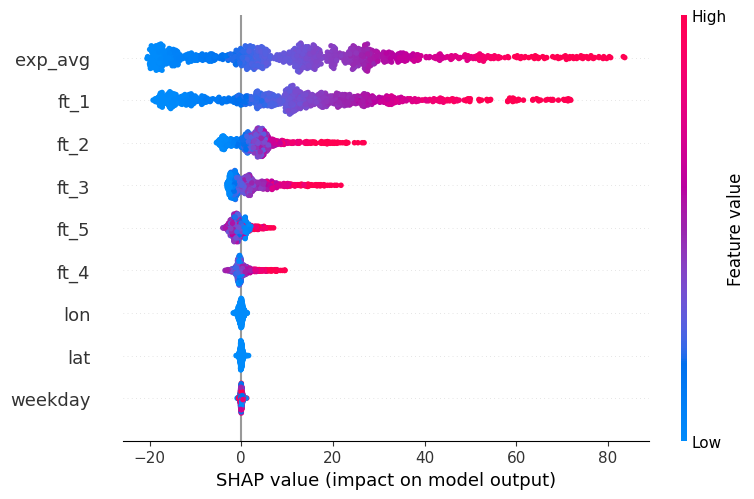

In [21]:
shap.summary_plot(shap_values_rf, x_test[0:1000])

### Q10 (5pts): Is `weekday` showing as an important factor on prediction explanations via SHAP?


Weekday is not showing as an important factor on the prediction explanations via SHAP. It is at the bottom of the list and sits around 0.

## XGBoost Feature Importance

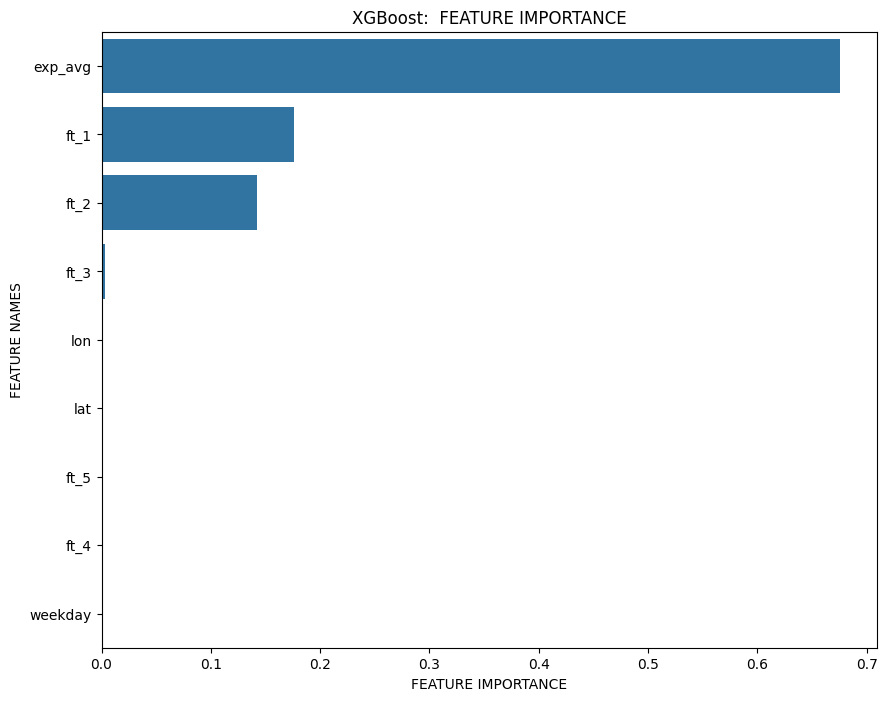

In [22]:
plot_feature_importance(regr_xgb.feature_importances_,x_train.columns,'XGBoost')

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


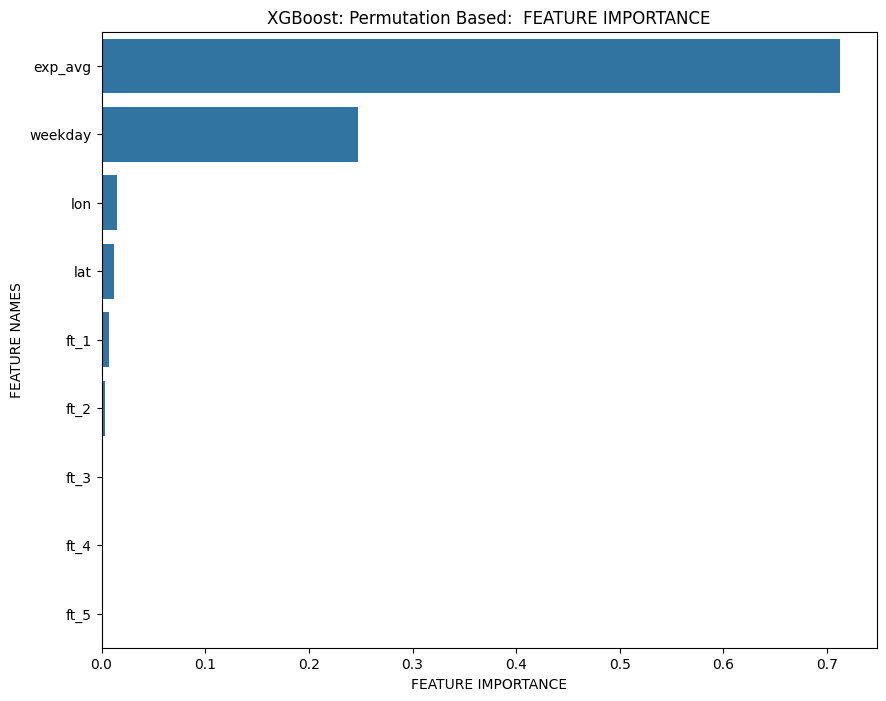

In [23]:
permutation_based_feature_importance_xgb = permutation_based_feature_importance(x_train, y_train, mse_train_xgb, regr_xgb)

plot_feature_importance(permutation_based_feature_importance_xgb,x_train.columns,'XGBoost: Permutation Based')

### Q11 (10pts): Based on the permutation-method feature importance chart for the XGBoost model, would you recommend that the model take out the less influential variables ft_1, ft_2, ft_3, ft_4, and ft_5 ?  Why or why not?


Based on the permutation-method feature importance chart, I would suggest that some of these features are removed. They are not really having an impact on the model and according to Occam's razor we typically want a simpler model. 

## XGBoost Feature Analysis

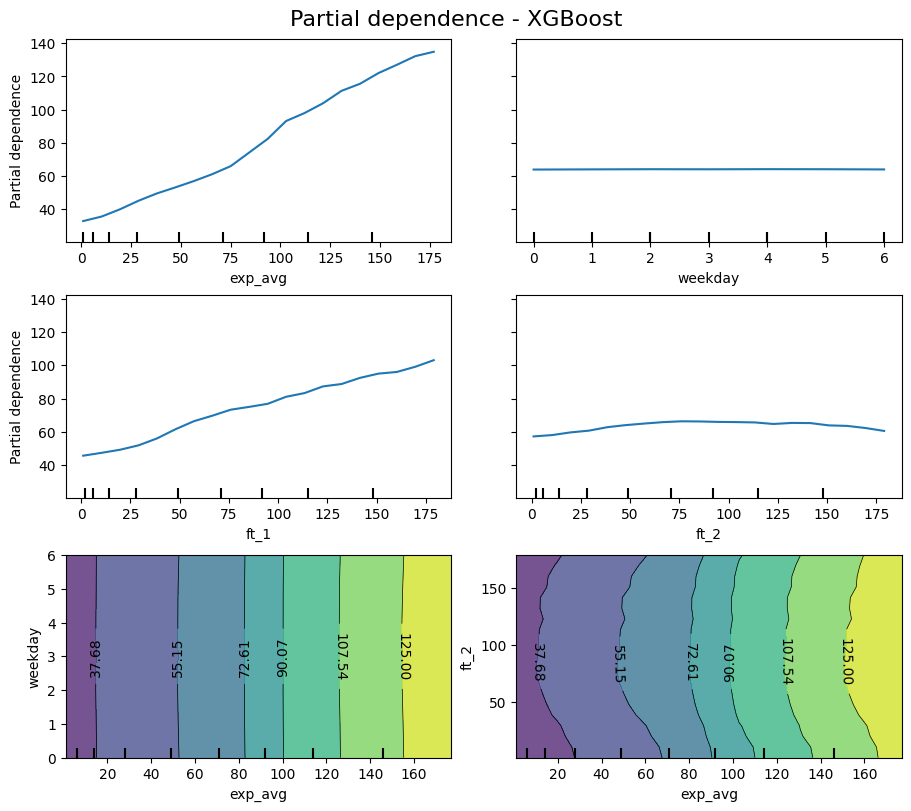

In [24]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_xgb,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - XGBoost"),fontsize=16)

In [25]:
explainer_xgb = shap.Explainer(regr_xgb, x_train)
shap_values_xgb = explainer_xgb(x_test[0:100])

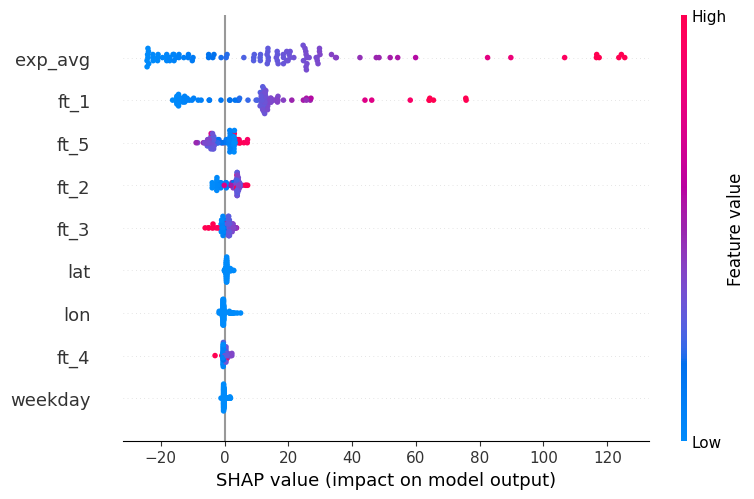

In [26]:
shap.summary_plot(shap_values_xgb, x_test[0:100])

## MLP Feature Importance

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


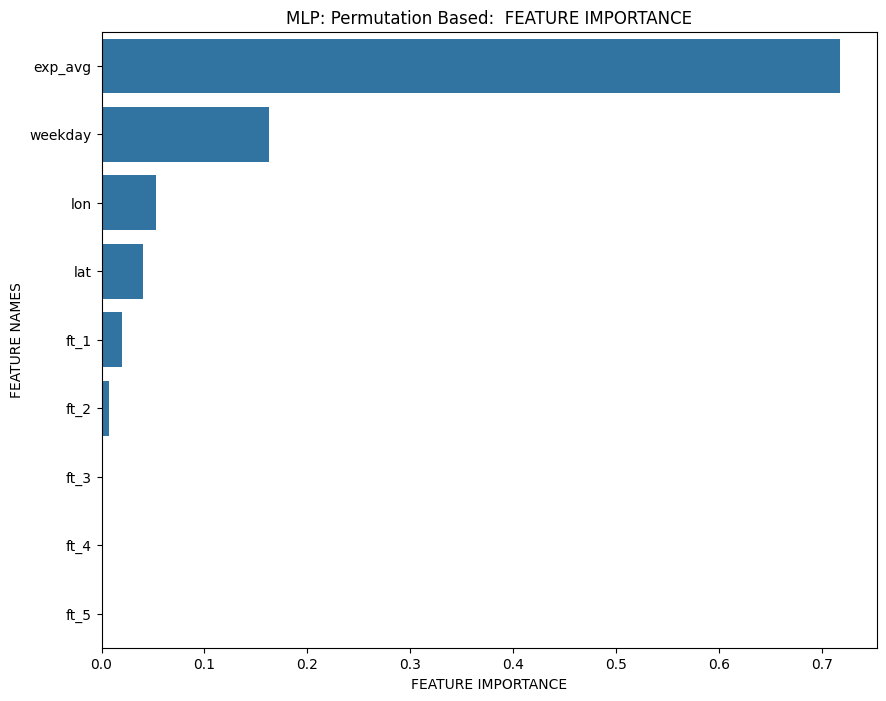

In [27]:
permutation_based_feature_importance_mlp = permutation_based_feature_importance(x_train, y_train, mse_train_mlp, regr_mlp)

plot_feature_importance(permutation_based_feature_importance_mlp,x_train.columns,'MLP: Permutation Based')

## MLP Feature Analysis

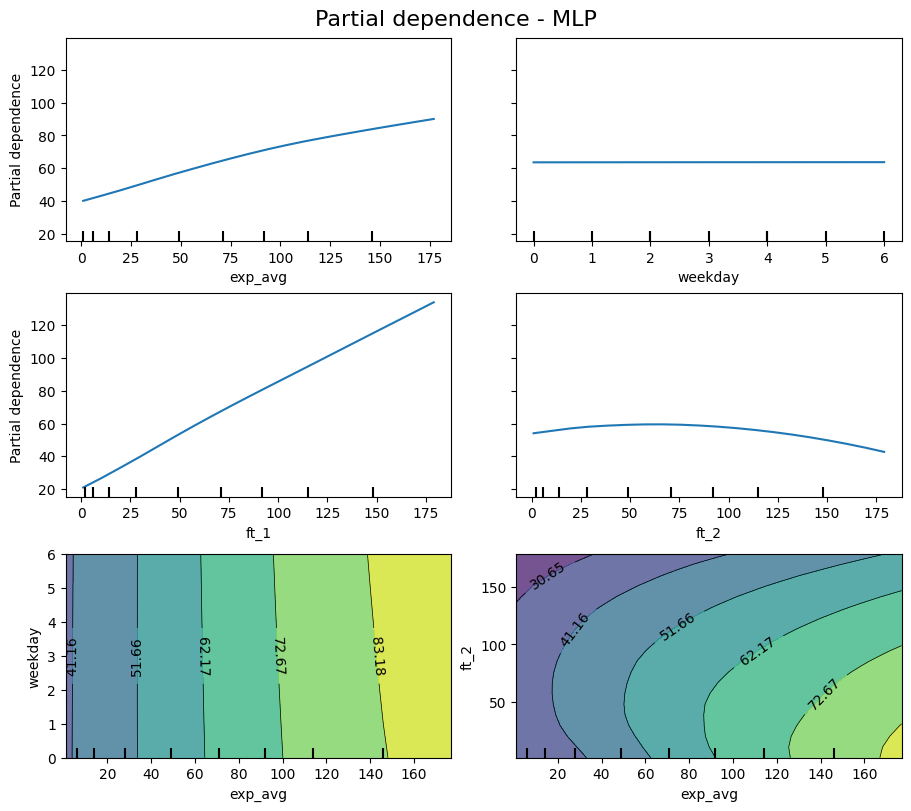

In [28]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_mlp,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - MLP"),fontsize=16)

In [29]:
# for NN, we use 'KernelExplainer', but it's very very slow. So we use 'shap.sample' to sample a subset.
n_samples = 100
explainer_mlp = shap.KernelExplainer(regr_mlp.predict, shap.sample(x_train, n_samples))

In [30]:
shap_values_mlp = explainer_mlp(x_test[0:100])

100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


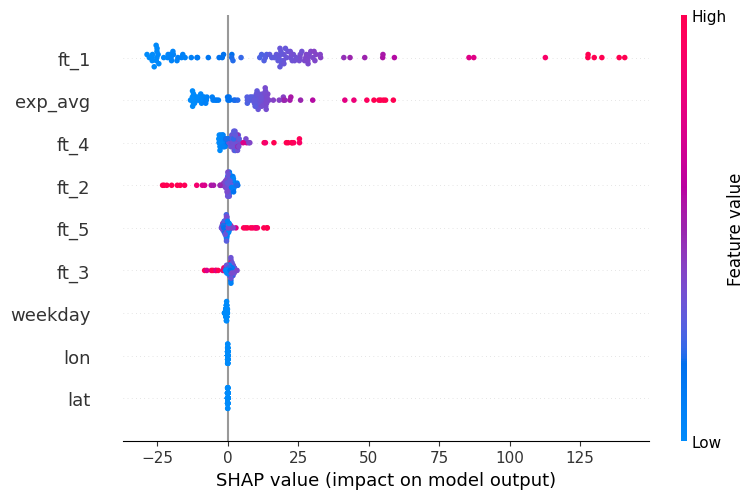

In [31]:
shap.summary_plot(shap_values_mlp, x_test[0:100])

# Local Explainability

## Random Forest SHAP

In [32]:
x_test[:1]

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,235,234,243,277,268,40.732211,-74.003238,0,267


In [33]:
print('Actual:', y_test['target'].iloc[0], 'Random Forest:', y_pred_rf[:1], 'XGBoost:', y_pred_xgb[:1], 'MLP:', y_pred_mlp[:1])

Actual: 247 Random Forest: [261.60553648] XGBoost: [272.72708] MLP: [261.09911755]


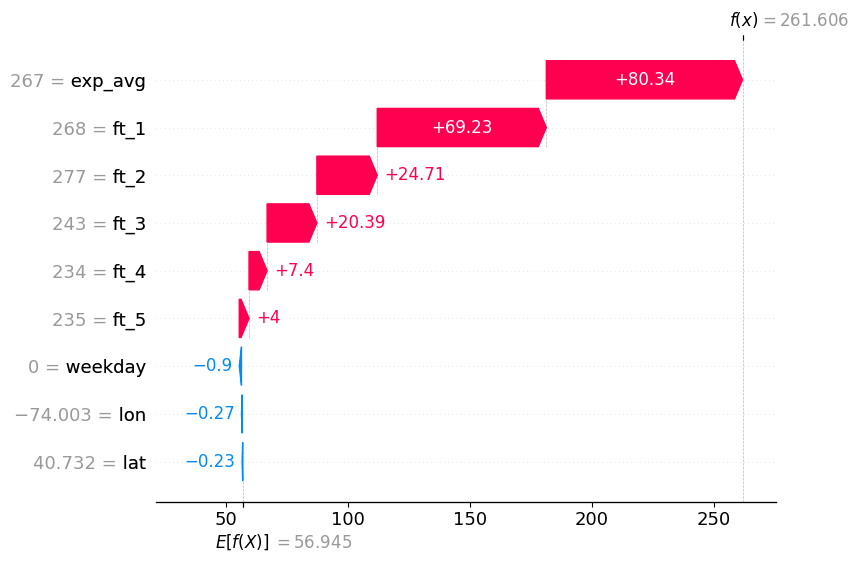

In [34]:
shap.plots.waterfall(shap_values_rf[0])

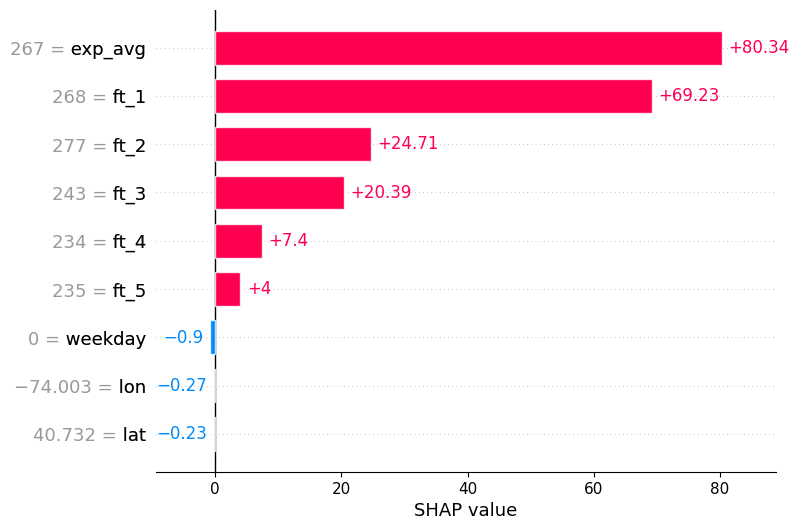

In [35]:
shap.plots.bar(shap_values_rf[0])

### Q12 (5pts): What is the difference between the plots shown by `shap.plots.waterfall` and `shap.plots.bar`?

The shap.plots.waterfall shows the SHAP value for a single prediction, while the shap.plots.bar shows the mean absolute SHAP value for a feature across all predictions in the dataset. The waterfall plot is good for understanding how different features impact a specific prediction, while the bar shows the overall importance of features across all predictions.

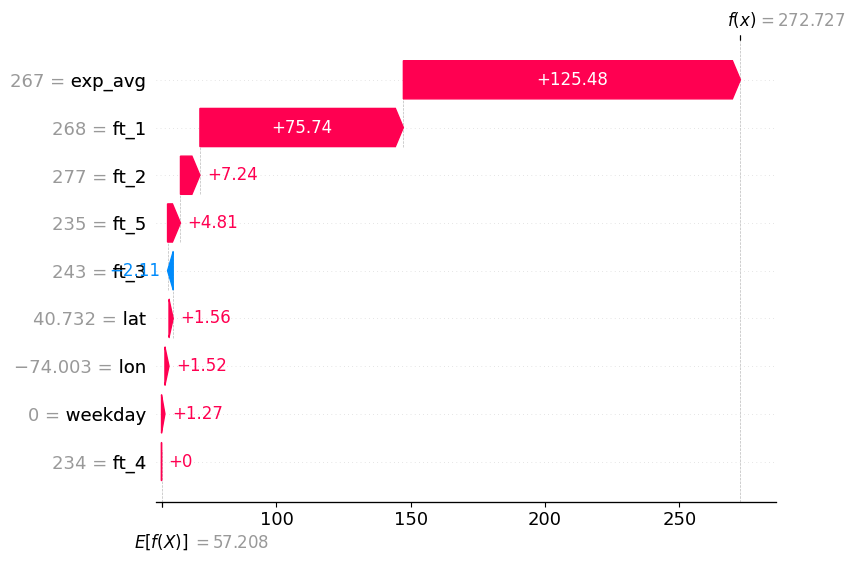

In [36]:
shap.plots.waterfall(shap_values_xgb[0])

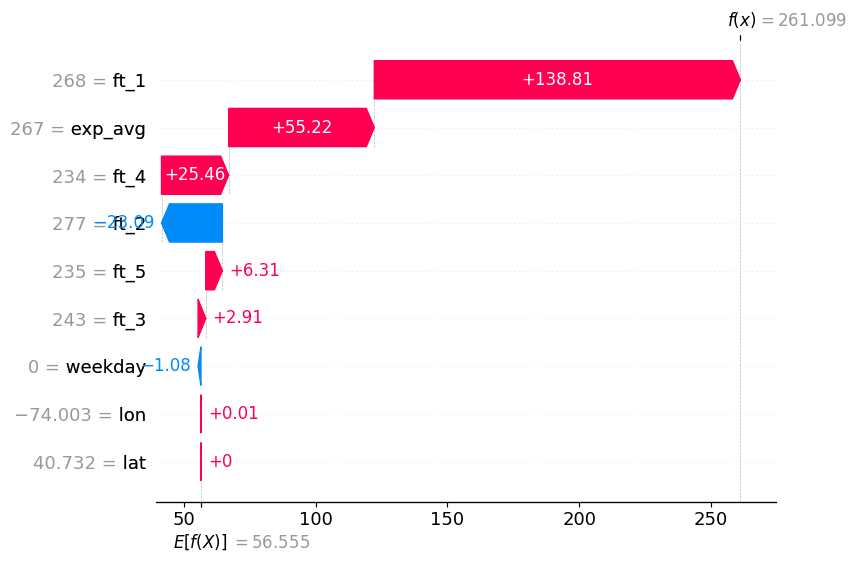

In [37]:
shap.plots.waterfall(shap_values_mlp[0])

### Q13 (5pts): How is it possible that two models (like the XGBoost and MLP models above) can have very similar permutation feature importance but very different SHAP explanations for the same data point?

With permutation we are measuring how important features are across the whole dataset (global), while with SHAP we are valuing the contributions of each feature for a specific datapoint (local). 

In [38]:
test_prediction = x_test[0:1].assign(lon=-95.369804,lat=29.760427)
test_prediction

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,235,234,243,277,268,29.760427,-95.369804,0,267


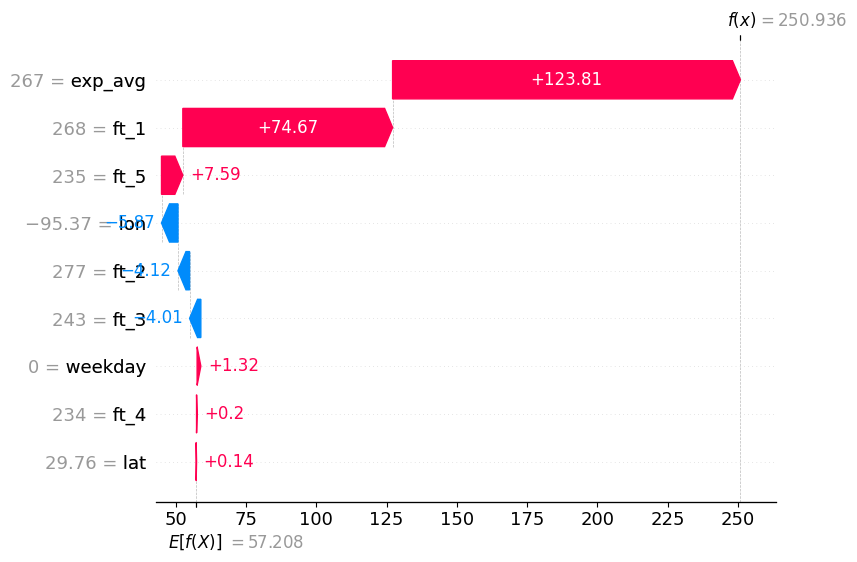

In [39]:
shap_values_test = explainer_xgb(test_prediction)
shap.plots.waterfall(shap_values_test[0])

### Q14 (5pts): Are feature effects independent from each other in our SHAP XGBoost explainer?

Features are not independent from each other in SHAP. SHAP is designed to show the contributions of individual features, but the SHAP framework assumes and accounts for the relationship between features on the backend. 

### Q15 (5pts): `lon=-95.369804,lat=29.760427` is Houston, TX.  What would a data scientist need to do to create good explanations for this region?

This dataset was looking at Taxi Rides in NYC; if we wanted to do something similar to get explanations for the Houston Region we would follow a similar approach. 

 We would collect and prepare the data; this was already done for us in the NYC example. We would then clean the data, and traina  few different predictive models. Once we have some with good predicive power we would explore the feature importance rankings using things such as gini, permutation-based, partial depdencies, SHAP values. Then create some analysis.
